In [25]:
from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
from mobo.transformation import StandardTransform
import numpy as np

In [26]:
sm = BoTorchSurrogateModelReapeat(n_var=1, n_obj=1, alpha=0.9, n_w=11)

# data normalization
transform = StandardTransform(x_bound=np.array([[0], [1]]))


def f(X):
    #sine function
    return 1.*np.sin(X*4*np.pi) + 3*X**2 -2.

#sigmoid at 0.5
def sigmoid(X):
    return 1/(1+np.exp(-10*(X-0.5)))

def noise_amplitude(X):
    return np.sin(1.5*np.pi*X)**2

def init():
    steps_size = 0.01
    X = np.arange(0, 1, steps_size).reshape(-1, 1)
    x_pred = np.arange(0, 1, steps_size).reshape(-1, 1)
    Y_true = f(X)
    sigma = 2.
    repeats = 100
    # rho = sigma*sigmoid(X)
    rho = sigma*noise_amplitude(X)
    Y_true = np.stack([Y_true] * repeats, axis=-1)
    Y_full = Y_true + np.expand_dims(rho, -1) * np.random.randn(*Y_true.shape)
    X_full = np.stack([X] * repeats, axis=-1)
    return X, X_full, Y_full, x_pred


In [27]:
from typing import List
import numpy as np
import torch

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

from botorch.models.gp_regression import (
    HeteroskedasticSingleTaskGP,
    SingleTaskGP,
)

from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.likelihoods import LikelihoodList
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_model, fit_gpytorch_mll_torch
from botorch.models.transforms.outcome import Standardize, Log

import gpytorch
import torch

from mobo.surrogate_model.botorch_helper import CustomHeteroskedasticSingleTaskGP


def initialize_model(train_x, train_y, train_rho=None):
    train_x = torch.tensor(train_x, **tkwargs)
    train_y_mean = torch.tensor(train_y, **tkwargs) + 1e-6
    train_y_var = torch.tensor(train_rho, **tkwargs) + 1e-6

    models = []
    for i in range(train_y_mean.shape[1]):
        model = SingleTaskGP(
            train_X=train_x,     
            train_Y=train_y_mean[..., i:i+1],
            # train_Yvar=train_y_var[..., i:i+1],
            # input_transform=self.input_transform,
            # outcome_transform=Standardize(m=1),            
            outcome_transform=Log(),            
            )            
        
        models.append(model)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll, max_retries=5)

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll, max_retries=5)
    return model


In [32]:
# VARIANCE
X, X_full, Y_full, x_pred = init()
Y = Y_full.mean(axis=-1)
Y_var = Y_full.var(axis=-1)

#normal distributed noise
# Y += rho*np.random.normal(0, 1., Y.shape)

transform.fit(X, Y)
mu = Y.mean()
std = Y.std()
print(mu, std)
print(transform.y_scaler.mean_, transform.y_scaler.scale_)
# x, y = transform.do(X, Y)
x, y, y_var = transform.do(X, Y, Y_var)
y, y_var = Y, Y_var

print(x.mean(), x.std())
print(y.mean(), y.std())


# x,y = X,Y
# rho = self.rho

sm.fit(x, y, y_var)

var = sm.evaluate(X=x_pred, noise=True)
y_pred = var['F']
y_var_pred = var['rho_F']
X_pred, Y_pred, Y_var_pred = transform.undo(x_pred, y_pred, y_var_pred) 
Y_pred, Y_var_pred = y_pred, y_var_pred
# S_pred = var['S']
# rho_pred = var['rho_F']
rho_pred = Y_var_pred



-1.0226349955117449 0.9220605039624764
[-1.022635] [0.9220605]
0.49499999999999994 0.2886607004772212
-1.0226349955117449 0.9220605039624764
rho statistics
mean: 1.4657872711219893, std: 1.5077732493772045, min: 0.0, max: 5.044259503494924


In [33]:
print(rho_pred.max())
print(rho_pred.max()**2)
print(rho_pred.max()**0.5, "\n")

print(Y_var.max())
print(Y_var.max()**2)
print(Y_var.max()**0.5, "\n")

print(Y_pred.std())
print(y_pred.std())

print(y_var.var())

4.963687231525304
24.638190932407337
2.2279333992571018 

5.044259503494924
25.444553938598858
2.2459428985383676 

0.9151266665027592
0.9151266665027592
2.2506463698221193


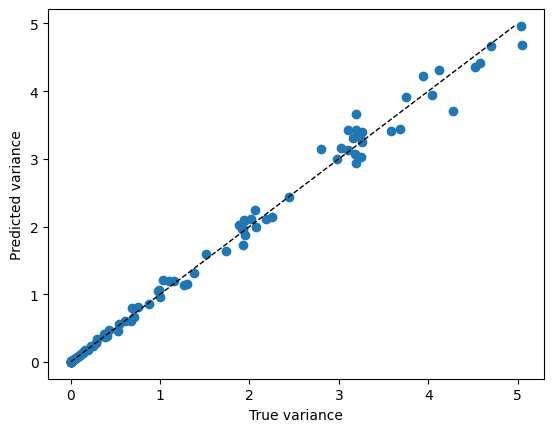

In [34]:
# rho vs rho_pred
import matplotlib.pyplot as plt
# plt.plot(X, rho)
plt.scatter(Y_var, rho_pred)
#diag
plt.plot([0, rho_pred.max()], [0, rho_pred.max()], 'k--', lw=1)
plt.xlabel('True variance')
plt.ylabel('Predicted variance')
 
# plt.xlim([0, rho_pred.max()])
# plt.ylim([0, rho_pred.max()])

plt.show()
 

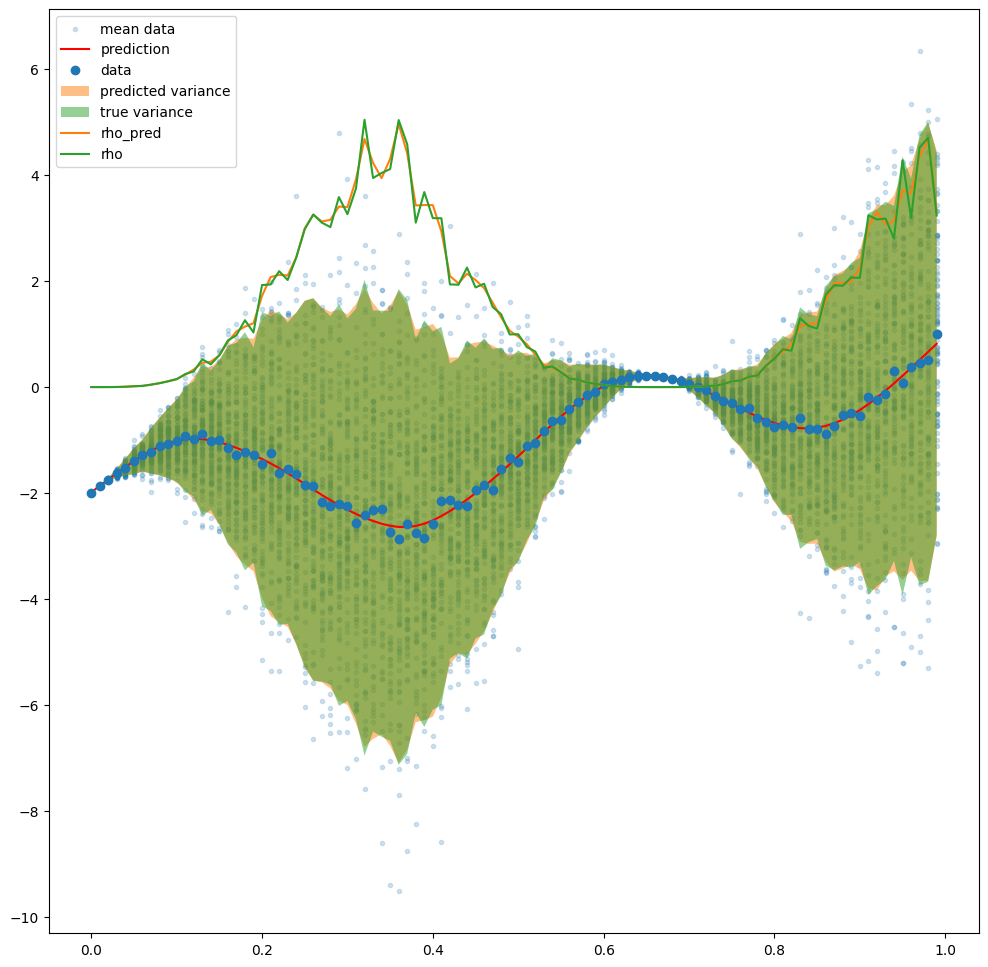

In [35]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(12, 12))

# X-full over Y-full
ax = axes
ax.scatter(X_full.flatten(), Y_full.flatten(), label='mean data', alpha=0.2, marker='.')
ax.plot(X_pred, Y_pred, label='prediction', color='r')
 
# ax = axes[0]
ax.plot(X, Y, 'o', label='data')
ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*rho_pred.flatten()**0.5, Y_pred.flatten()+2*rho_pred.flatten()**0.5, alpha=0.5, label='predicted variance')
ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*Y_var.flatten()**0.5, Y_pred.flatten()+2*Y_var.flatten()**0.5, alpha=0.5, label='true variance')
# ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*rho_pred.flatten(), Y_pred.flatten()+2*rho_pred.flatten(), alpha=0.5, label='predicted variance')
# ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*Y_var.flatten(), Y_pred.flatten()+2*Y_var.flatten(), alpha=0.5, label='true variance')
ax.plot(X, rho_pred, label='rho_pred')
ax.plot(X, Y_var, label='rho')
ax.legend()


plt.show()

In [36]:

# n_grid = 25
# x2 = np.linspace(0, 1, n_grid)
# x1 = np.linspace(0, 1, n_grid)
# x1_mesh, x2_mesh = np.meshgrid(x1, x2)
# x_mesh = np.vstack((x1_mesh.flatten(), x2_mesh.flatten())).T
# if pset.shape[1] > 2:
#     # other vars constant 0.5
#     x_mesh = np.hstack(
#         (x_mesh, np.full((n_grid**2, pset.shape[1] - 2), 0.5))
#     )

# val = self.optimizer.surrogate_model.evaluate(x_mesh, std=True, noise=True)

# for key in val:
#     if val[key] is None:
#         continue
#     if val[key].ndim == 1:
#         d4[key] = val[key]
#     else:
#         for i in range(val[key].shape[1]):
#             col_name = f"{key}_{i + 1}"
#             d4[col_name] = val[key][:, i]

# # add iteration id and x1, x2 columns
# d4["iterID"] = np.full(n_grid**2, self.iter, dtype=int)

# X_mesh, Y_mesh = self.transformation.undo(x_mesh, val["F"])
# rho_mesh = val["rho_F"]

# mvar_F_mesh = calculate_var(Y_mesh, std=rho_mesh, alpha=self.alpha)
